In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import torch, torch.nn as nn
import norse
import sys
import norse.torch as norse
from time import perf_counter
from array2gif import write_gif
import scripts
from scripts.input_generation import *
from scripts.visualization import *
from scripts.cib import *
from scripts.weights import *
from scripts.motorControl import *

# Dataset creation
We simulate a set of movements (to the left, to the right, up and down) as if they were outputs of a DVS camera.

In [2]:
#Initialization of the parameters of our simulation
x = 41 
y = 41       #Size of our input. For simplicity, we use a square image
dt = 0.001    #Timestep of our simulation
duration = 1  #Duration of the movement

x_p = 3                    #Size of the object moving within the frame
y_p = 3
point = np.ones((x_p,y_p))

nb_samples, nb_repetitions = set_params(x,y,duration,dt)

print(nb_samples)
print(nb_repetitions)

sim_input, dvs_output = input_generator(x,y,point,nb_samples,nb_repetitions,dt,input_type="movement")
print_gif(sim_input)
print_gif(dvs_output)

20
50


# Creation of the architecture

In this section, we will try to reproduce the results of a model by Praveenram Balachandar and Konstantinos P. Michmizos [available here](https://ieeexplore.ieee.org/document/9224303), the left part model to be precise of the figure (e) to be precise : 

![figure](https://ieeexplore.ieee.org/mediastore_new/IEEE/content/media/9219774/9224269/9224303/balac1-0070-large.gif)

Until the end of the notebook, we will consider the movement of an object going up.

The documentation and code of the Norse functions being used in this notebook can be found [here](https://github.com/norse/norse/blob/master/norse/torch/functional/izhikevich.py) and module can be found [here](https://github.com/norse/norse/blob/master/norse/torch/module/izhikevich.py)

In [3]:
#Import of the Izhikevich module and functions from Norse
from norse.torch.module import izhikevich as izk
from norse.torch.functional.izhikevich import *

In [4]:
#Creation of a weight matrix
weights_ini = np.zeros((x,y))
for i in range(x):
    if i <= (x-1)/2 :
        weights_ini[i,:]+=(1-(2*i/(x-1)))

In [5]:
#Definition of the parameters of the Izhikevich neuron models
LLBN_behaviour = createIzhikevichSpikingBehaviour(0.1,-0.075,-55,6,-60,-60,tau_inv=250)
behaviours = [LLBN_behaviour,phasic_bursting,phasic_spiking,tonic_spiking]

In [6]:
#Definition of the network
class Network(torch.nn.Module):
    def __init__(self, weight_matrix):
        super(Network, self).__init__()     
        self.LLBN = izk.IzhikevichRecurrentCell(1, 1, LLBN_behaviour, autapses=True, 
                                                input_weights=weights_matrix[2]*torch.ones(1),
                                                recurrent_weights=weights_matrix[3]*torch.ones(1), dt=dt)
        self.EBN = izk.IzhikevichCell(phasic_bursting, dt=dt)
        self.IFN = izk.IzhikevichCell(phasic_spiking, dt=dt)
        self.TN = izk.IzhikevichRecurrentCell(1, 1, tonic_bursting, autapses=True, 
                                              input_weights=weights_matrix[9]*torch.ones(1), 
                                              recurrent_weights=weights_matrix[10]*torch.ones(1), dt=dt)
        self.MN = izk.IzhikevichCell(phasic_spiking, dt=dt)
        self.s_2 = None
        self.s_3 = phasic_bursting.s
        self.s_4 = phasic_spiking.s
        self.s_5 = None
        self.s_6 = phasic_spiking.s
        
    def forward(self, input_mat, weights_matrix):        
        v = np.zeros((1,))
        
        o_spikes = np.zeros((1,))
        
        temp = torch.zeros((1,))
        
        input_matrix = input_mat * weights_matrix[0]
        z_1 = np.reshape(input_matrix, (x*y,))
        z_plus = z_1.sum()
        z_2, self.s_2 = self.LLBN(torch.tensor(z_plus*weights_matrix[1]-temp.detach().numpy()).float(), self.s_2)
        #v[0] = self.s_2.v.detach().numpy()
        #o_spikes[0] = z_2.detach().numpy()

        z_in = z_plus*weights_matrix[4] + z_2*weights_matrix[5]
        z_3, self.s_3 = self.EBN(z_in, self.s_3)
        #v[1] = self.s_3.v.detach().numpy()
        #o_spikes[1] = z_3.detach().numpy()

        z_4, self.s_4 = self.IFN(z_3*weights_matrix[6], self.s_4)
        temp = z_4*weights_matrix[7]
        #v[2] = self.s_4.v.detach().numpy()
        #o_spikes[2] = z_4.detach().numpy()

        z_5, self.s_5 = self.TN(z_3.float()*weights_matrix[8], self.s_5)
        #v[3] = self.s_5.v.detach().numpy()
        #o_spikes[3] = z_5.detach().numpy()

        z_6, self.s_6 = self.MN(z_5*weights_matrix[11], self.s_6)
        #v[4] = self.s_6.v.detach().numpy()
        #o_spikes[4] = z_6.detach().numpy()
        o_spikes = z_6.detach().numpy()
        v = self.s_6.v.detach().numpy()
        return o_spikes, v

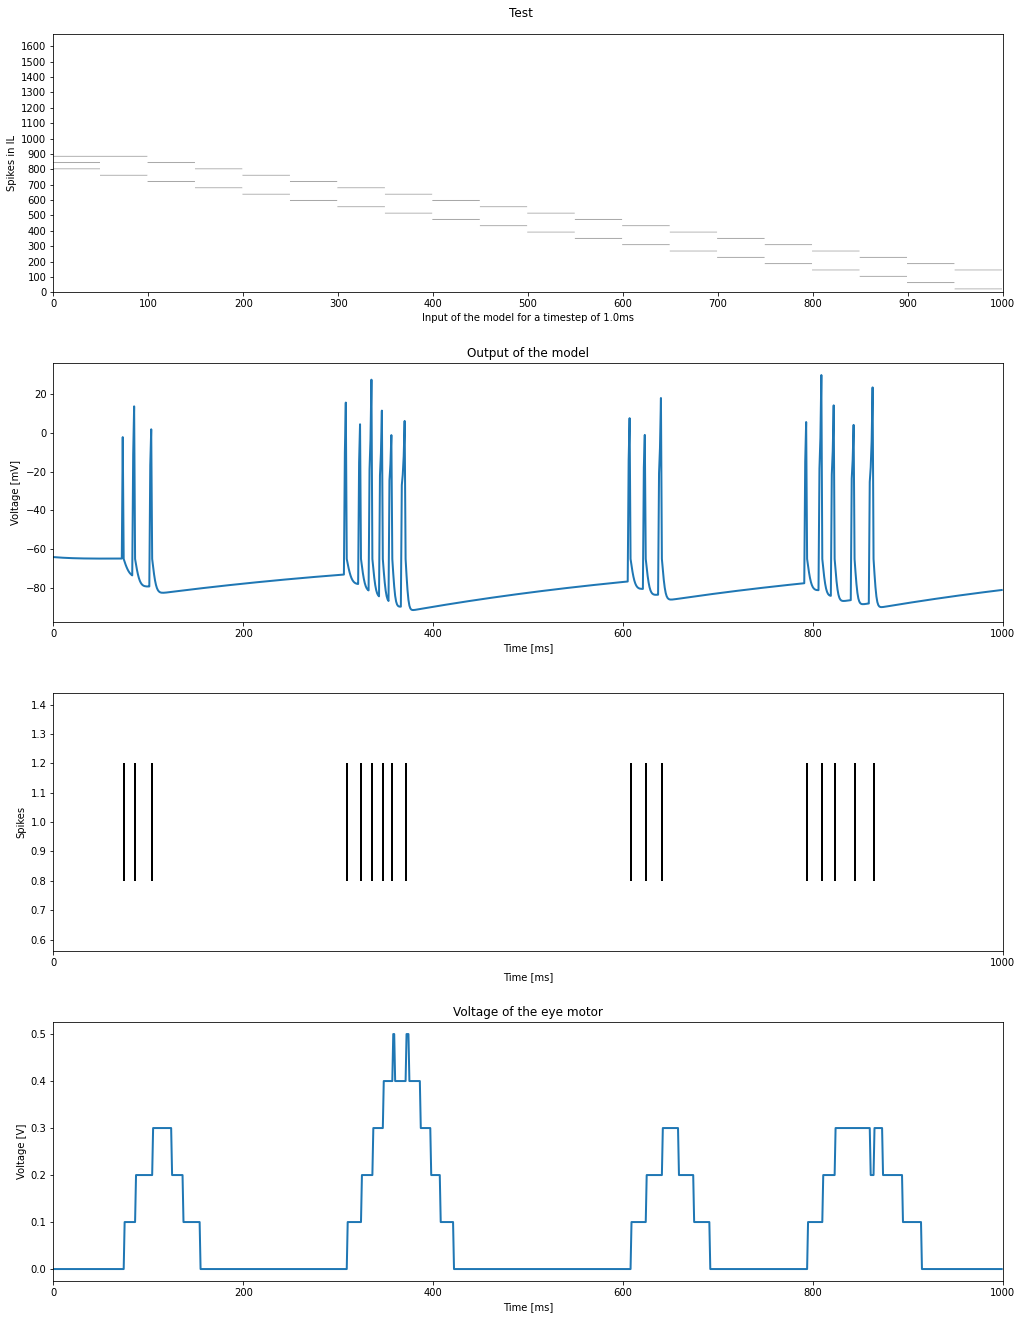

In [24]:
#Create weight matrix
weights_matrix = create_weights(
    weight_fovea = weights_ini,
    weight_to_LLBN = 5,
    weight_LLBN_input = 5,
    weight_LLBN_recurrent = 5,
    weight_to_EBN = 7.5,
    weight_LLBN_EBN = 7.5,
    weight_EBN_IFN = 50,
    weight_IFN_LLBN = 50,
    weight_EBN_TN = 30,
    weight_TN_input = 2,
    weight_TN_recurrent = 5,
    weight_TN_MN = 250
)

#Create model
model = Network(weights_matrix)

#Create output spikes and voltage variables
o_tot = np.zeros((nb_repetitions*nb_samples,))
v_tot = np.zeros((nb_repetitions*nb_samples,))
i_tot = np.zeros((x*y,nb_repetitions*nb_samples))
v_motor = np.zeros((nb_repetitions*nb_samples,))

#Run simulation
for i in range(nb_samples):
    for ts in range(nb_repetitions):
        o, v = model(dvs_output[i], weights_matrix)
        i_tot[:,(i)*nb_repetitions+ts] += np.reshape(dvs_output[i],(x*y,))
        o_tot[i*nb_repetitions+ts] += o
        v_tot[i*nb_repetitions+ts] += v
        if i*nb_repetitions+ts > nb_repetitions:
            v_motor[i*nb_repetitions+ts] = convertSpikesToVoltage(o_tot[(i-1)*nb_repetitions+ts
                                                                        :i*nb_repetitions+ts])
output_visualisation(i_tot,o_tot,v_tot,v_motor,"Test",nb_repetitions,dt)